In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [237]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df=pd.read_csv("./playground-series-s5e5/train.csv")
test_df=pd.read_csv("./playground-series-s5e5/test.csv")

In [6]:
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x=="male" else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

In [7]:
test_ids=test_df['id']

In [8]:
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [9]:
def detecting_outliers(val):
    sns.boxplot(x=f'{val}', data=train_df)
    plt.title("Box plot")
    plt.show()

In [10]:
def get_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def cap_outliers_with_bounds(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for col in numerical_cols:
    lower, upper = get_iqr_bounds(train_df, col)
    train_df = cap_outliers_with_bounds(train_df, col, lower, upper)
    test_df = cap_outliers_with_bounds(test_df, col, lower, upper)

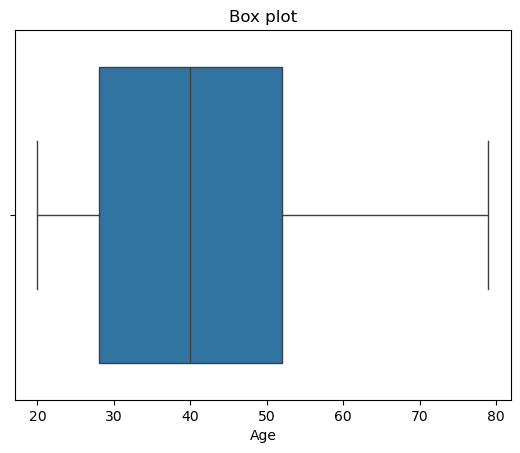

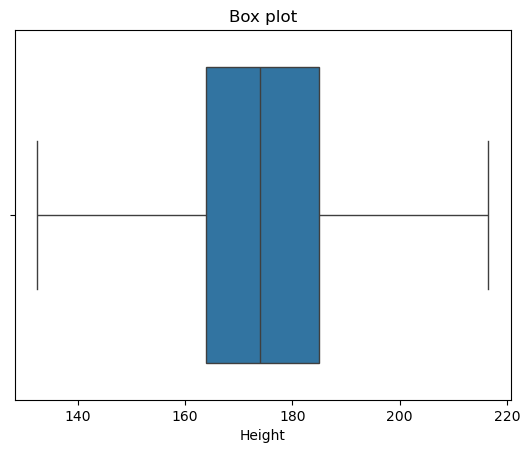

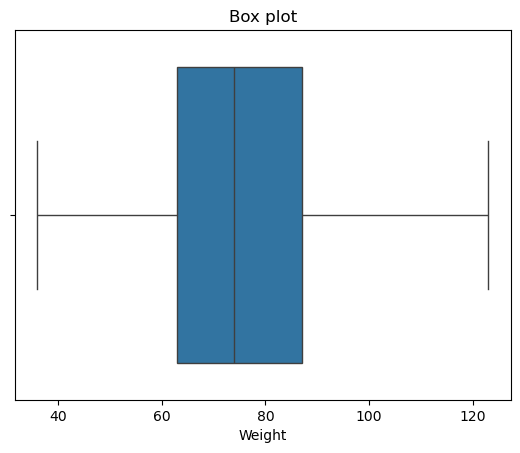

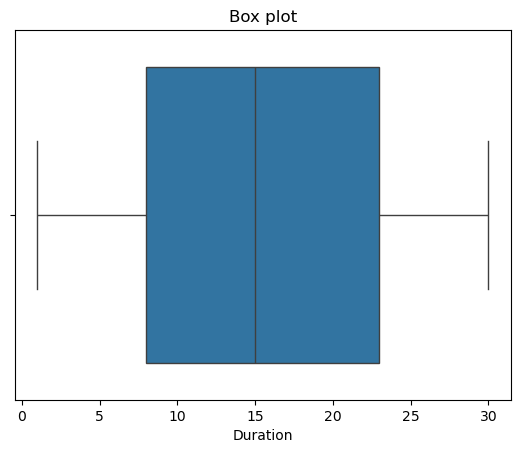

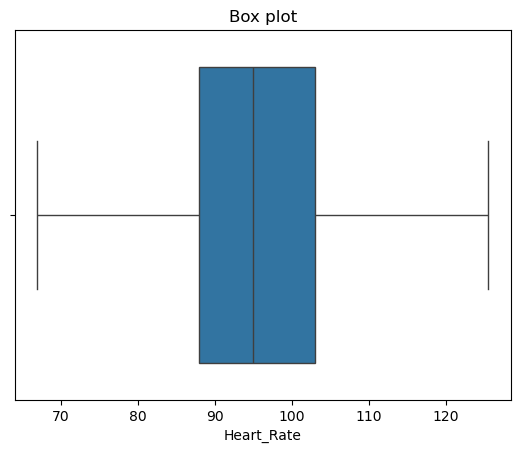

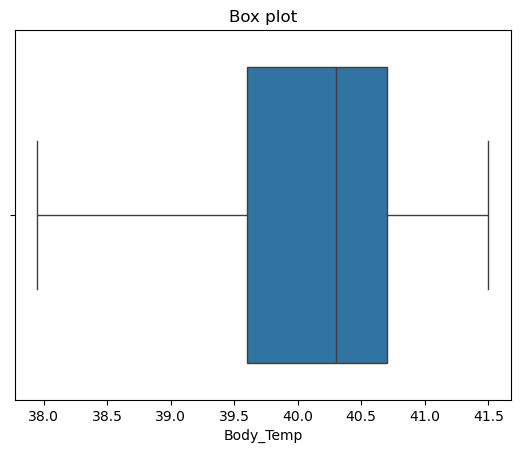

In [11]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

In [81]:
train_df1=train_df.copy()
test_df1=test_df.copy()

In [83]:
train_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0


In [85]:
#Train data
train_df1['Duration^2']=train_df1['Duration']**2
train_df1['Weight/Duration']=train_df1['Weight']/train_df1['Duration']
train_df1['Duration/Age']=train_df1['Duration']/train_df1['Age']
#train_df1['Age^2']=train_df1['Age']**2
train_df1['Duration_x_Hear_Rate']=train_df1['Duration']*train_df1['Heart_Rate']

#Test data
test_df1['Duration^2']=test_df1['Duration']**2
test_df1['Weight/Duration']=test_df1['Weight']/test_df1['Duration']
test_df1['Duration/Age']=test_df1['Duration']/test_df1['Age']
#test_df1['Age^2']=test_df1['Age']**2
test_df1['Duration_x_Hear_Rate']=test_df1['Duration']*test_df1['Heart_Rate']

In [15]:
X1=train_df1.drop(columns=['Calories'])
y1=train_df1['Calories']

In [16]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size=0.2)

In [17]:
scaler=StandardScaler()

X1_train_scaled=scaler.fit_transform(X1_train)
X1_test_scaled=scaler.transform(X1_test)

test_df1_scaled=scaler.transform(test_df1)

In [18]:
y1_train_log = np.log1p(y1_train)
y1_test_log = np.log1p(y1_test)

In [19]:
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X1_train_scaled, y1_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 11
[LightGBM] [Info] Start training from score 4.140092


LGBMRegressor(random_state=42)

In [20]:
lgb_pred_log = lgb_model.predict(X1_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [21]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06229019320393759


In [22]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X1_train_scaled, y1_train_log)

In [23]:
cat_pred_log = cat_model.predict(X1_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [24]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.06035356701660562


In [25]:
predictions10=cat_model.predict(test_df1_scaled)
predictions10=np.expm1(predictions10)

In [26]:
submission10=pd.DataFrame({'id': test_ids, 'Calories': predictions10})
submission10.to_csv('submission10.csv', index=False)
print("Submission10 file created")

Submission10 file created


In [27]:
rf_model=RandomForestRegressor(verbose=0, random_state=42)
rf_model.fit(X1_train_scaled, y1_train_log)

RandomForestRegressor(random_state=42)

In [28]:
rf_pred_log=rf_model.predict(X1_test_scaled)
rf_pred=np.expm1(rf_pred_log)

In [29]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, rf_pred))
print("Random Forest RMSLE:", rmsle)

Random Forest RMSLE: 0.06470902669829727


In [30]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X1_train_scaled, y1_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
xgb_pred_log = xgb_model.predict(X1_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [32]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06314684572937511


In [33]:
blended_pred_log = 0.2 * lgb_pred_log + 0.7 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y1_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.060249811742709644


In [34]:
lgb_test_log = lgb_model.predict(test_df1_scaled)
cat_test_log = cat_model.predict(test_df1_scaled)
xgb_test_log = xgb_model.predict(test_df1_scaled)

# Blend and reverse transform
final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [35]:
predictions13=np.expm1(final_pred_log)

In [36]:
submission13=pd.DataFrame({'id': test_ids, 'Calories': predictions13})
submission13.to_csv('submission13.csv', index=False)
print("Submission13 file created")

Submission13 file created


### Rank: 571/1919

In [75]:
train_df2=train_df.copy()
test_df2=test_df.copy()

In [79]:
train_df2['Duration^2']=train_df2['Duration']**2
test_df2['Duration^2']=test_df2['Duration']**2

In [196]:
train_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2


In [198]:
test_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration^2,Age_bin
0,1,45,177.0,81.0,7.0,87.0,39.8,49.0,3
1,1,26,200.0,97.0,20.0,101.0,40.5,400.0,1
2,0,29,188.0,85.0,16.0,102.0,40.4,256.0,1
3,0,39,172.0,73.0,20.0,107.0,40.6,400.0,2
4,0,30,173.0,67.0,16.0,94.0,40.5,256.0,1


In [200]:
X2=train_df2.drop(columns=['Calories'])
y2=train_df2['Calories']

In [202]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.2)

In [204]:
scaler=StandardScaler()

X2_train_scaled=scaler.fit_transform(X2_train)
X2_test_scaled=scaler.transform(X2_test)

test_df2_scaled=scaler.transform(test_df2)

In [206]:
y2_train_log = np.log1p(y2_train)
y2_test_log = np.log1p(y2_test)

In [208]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X2_train_scaled, y2_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 4.142035


LGBMRegressor(random_state=42)

In [210]:
lgb_pred_log = lgb_model.predict(X2_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [212]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06230200173979282


In [214]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X2_train_scaled, y2_train_log)

In [215]:
cat_pred_log = cat_model.predict(X2_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [218]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.05912706174241978


In [220]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X2_train_scaled, y2_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [222]:
xgb_pred_log = xgb_model.predict(X2_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [224]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06185491193609304


In [251]:
blended_pred_log = 0.1 * lgb_pred_log + 0.8 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y2_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.059086219682377164


In [228]:
lgb_test_log = lgb_model.predict(test_df2_scaled)
cat_test_log = cat_model.predict(test_df2_scaled)
xgb_test_log = xgb_model.predict(test_df2_scaled)


final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [230]:
predictions15=np.expm1(final_pred_log)

In [232]:
submission15=pd.DataFrame({'id': test_ids, 'Calories': predictions15})
submission15.to_csv('submission15.csv', index=False)
print("Submission15 file created")

Submission15 file created


## Rank: 331/2049

## Rank: 437/1923

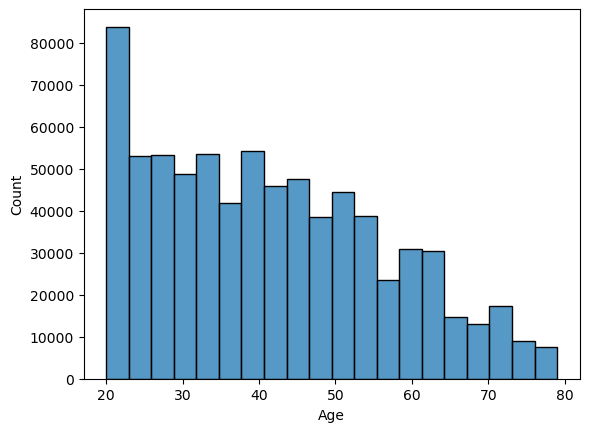

In [174]:
sns.histplot(train_df['Age'], bins=20)
plt.show()

In [182]:
train_df2['Age_bin']=pd.cut(train_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [194]:
test_df2['Age_bin']=pd.cut(test_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [184]:
train_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2


In [287]:
train_df3=train_df.copy()
test_df3=test_df.copy()

In [289]:
train_df3['Duration^2']=train_df3['Duration']**2
train_df3['Age_bin']=pd.cut(train_df3['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
train_df3['Duration_x_Age_bin']=train_df3['Duration']*train_df3['Age_bin']

test_df3['Duration^2']=test_df3['Duration']**2
test_df3['Age_bin']=pd.cut(test_df3['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
test_df3['Duration_x_Age_bin']=test_df3['Duration']*test_df3['Age_bin']

In [291]:
X3=train_df3.drop(columns=['Calories'])
y3=train_df3['Calories']

In [293]:
X3_train, X3_test, y3_train, y3_test=train_test_split(X3, y3, test_size=0.2)

In [295]:
scaler=StandardScaler()

X3_train_scaled=scaler.fit_transform(X3_train)
X3_test_scaled=scaler.transform(X3_test)

test_df3_scaled=scaler.transform(test_df3)

In [297]:
y3_train_log = np.log1p(y3_train)
y3_test_log = np.log1p(y3_test)

In [299]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X3_train_scaled, y3_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 10
[LightGBM] [Info] Start training from score 4.140743


LGBMRegressor(random_state=42)

In [301]:
lgb_pred_log = lgb_model.predict(X3_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [303]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.062327972147990324


In [305]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X3_train_scaled, y3_train_log)

In [307]:
cat_pred_log = cat_model.predict(X3_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [309]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.0589059154418146


In [311]:
predictions16=cat_model.predict(test_df3_scaled)
predictions16=np.expm1(predictions16)

In [313]:
submission16=pd.DataFrame({'id': test_ids, 'Calories': predictions16})
submission16.to_csv('submission16.csv', index=False)
print("Submission16 file created")

Submission16 file created


In [315]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X3_train_scaled, y3_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [317]:
xgb_pred_log = xgb_model.predict(X3_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [319]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.061245573575056486


In [333]:
blended_pred_log =  0.8 * cat_pred_log + 0.2 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y3_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05886315800712841


In [335]:
cat_test_log = cat_model.predict(test_df3_scaled)
xgb_test_log = xgb_model.predict(test_df3_scaled)


final_pred_log = 0.8 * cat_test_log + 0.2 * xgb_test_log

In [337]:
predictions17=np.expm1(final_pred_log)

In [339]:
submission17=pd.DataFrame({'id': test_ids, 'Calories': predictions17})
submission17.to_csv('submission17.csv', index=False)
print("Submission17 file created")

Submission17 file created


### Score decreased so it does not make sense

In [342]:
train_df4=train_df.copy()
test_df4=test_df.copy()

In [344]:
train_df4['Duration^2']=train_df4['Duration']**2
train_df4['Age_bin']=pd.cut(train_df4['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

test_df4['Duration^2']=test_df4['Duration']**2
test_df4['Age_bin']=pd.cut(test_df4['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [346]:
age_bin_means = train_df4.groupby('Age_bin')['Calories'].mean()


train_df4['Age_bin_TE'] = train_df4['Age_bin'].map(age_bin_means)
test_df4['Age_bin_TE'] = test_df4['Age_bin'].map(age_bin_means)

train_df4.drop('Age_bin', axis=1, inplace=True)
test_df4.drop('Age_bin', axis=1, inplace=True)

In [350]:
X4=train_df4.drop(columns=['Calories'])
y4=train_df4['Calories']

In [352]:
X4_train, X4_test, y4_train, y4_test=train_test_split(X4, y4, test_size=0.2)

In [354]:
scaler=StandardScaler()

X4_train_scaled=scaler.fit_transform(X4_train)
X4_test_scaled=scaler.transform(X4_test)

test_df4_scaled=scaler.transform(test_df4)

In [356]:
y4_train_log = np.log1p(y4_train)
y4_test_log = np.log1p(y4_test)

In [358]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X4_train_scaled, y4_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 4.141622


LGBMRegressor(random_state=42)

In [360]:
lgb_pred_log = lgb_model.predict(X4_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [362]:
rmsle = np.sqrt(mean_squared_log_error(y4_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.0615526283085974


In [392]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X4_train_scaled, y4_train_log)

In [393]:
cat_pred_log = cat_model.predict(X4_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [396]:
rmsle = np.sqrt(mean_squared_log_error(y4_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.05850968194503338


In [398]:
predictions18=cat_model.predict(test_df4_scaled)
predictions18=np.expm1(predictions18)

In [400]:
submission18=pd.DataFrame({'id': test_ids, 'Calories': predictions18})
submission18.to_csv('submission18.csv', index=False)
print("Submission18 file created")

Submission18 file created


In [370]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X4_train_scaled, y4_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [372]:
xgb_pred_log = xgb_model.predict(X4_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [374]:
rmsle = np.sqrt(mean_squared_log_error(y4_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.061537539411142185


In [384]:
blended_pred_log = 0.1 * lgb_pred_log + 0.8 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y4_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05842857502550086


In [386]:
lgb_test_log = lgb_model.predict(test_df4_scaled)
cat_test_log = cat_model.predict(test_df4_scaled)
xgb_test_log = xgb_model.predict(test_df4_scaled)


final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [388]:
predictions18=np.expm1(final_pred_log)

In [390]:
submission18=pd.DataFrame({'id': test_ids, 'Calories': predictions18})
submission18.to_csv('submission18.csv', index=False)
print("Submission18 file created")

Submission18 file created
